In [1]:
# http://arohatgi.info/WebPlotDigitizer/app/
# http://arxiv.org/abs/1107.4367

In [2]:
%pylab inline
from scipy.special import erf

rc('text', usetex=True, fontsize=28)

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = loadtxt('Westphal-BX154_kulas_data.csv', delimiter=',')

x = data[:,0]/(1+2.5954) #redshift z = 2.5954
y = data[:,1]

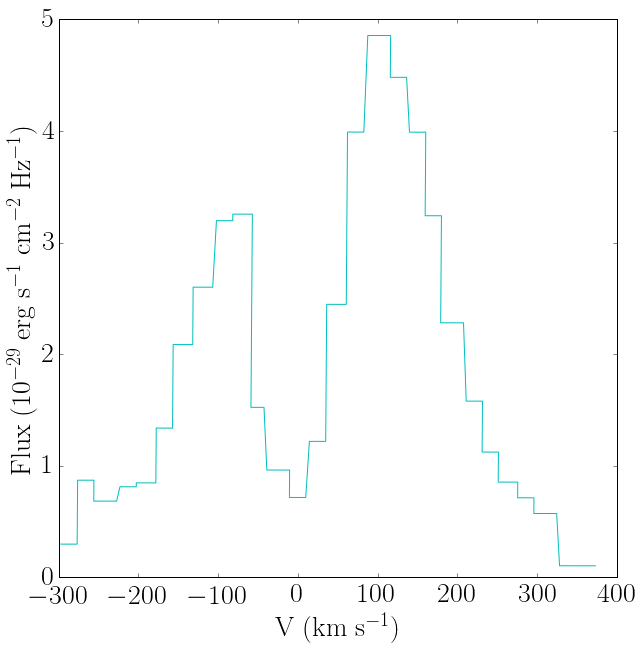

In [4]:
f = figure(figsize = (10,10))
plot(x,y,c='c')
xlabel('$\mathrm{V\;(km\;s^{-1})}$')
ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')
savefig('observation_v.png')

In [5]:
v_th = -12.8
x_x = flipud(x/v_th)
y_x = flipud(y)

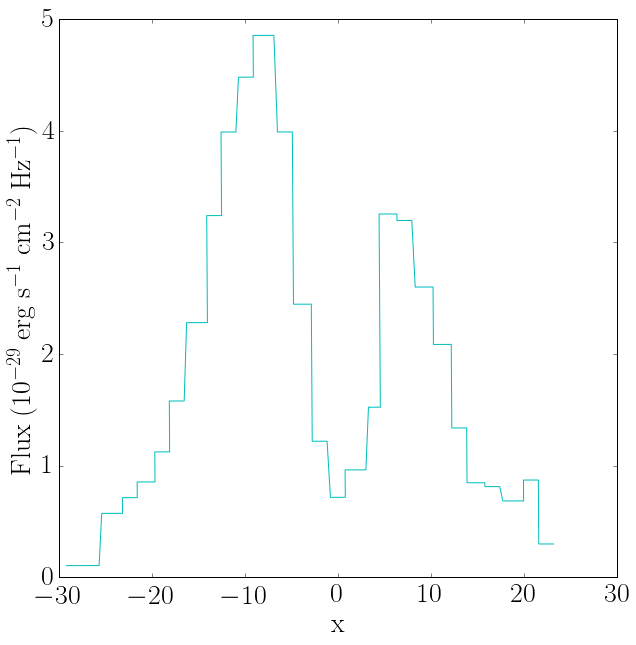

In [6]:
f = figure(figsize = (10,10))
plot(x_x,y_x,c='c')
xlabel('$\mathrm{x}$')
ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')
savefig('observation_x.png')

In [7]:
#MCMC Fit

def gaussian(x, amplitude, center, sigma):
    """1 dimensional gaussian:
    gaussian(x, amplitude, center, sigma)
    """
    return (amplitude/(sqrt(2*pi)*sigma)) * exp(-(1.0*x-center)**2 /(2*sigma**2))

#Based on the definition in: https://github.com/lmfit/lmfit-py/blob/master/lmfit/lineshapes.py
def sum_2_skewed_gaussian(x, amplitude_neg, center_neg, sigma_neg, gamma_neg, amplitude_pos, center_pos, sigma_pos, gamma_pos):
    """Gaussian, skewed with error function, equal to
     gaussian(x, center, sigma)*(1+erf(beta*(x-center)))
    with beta = gamma/(sigma*sqrt(2))
    with  gamma < 0:  tail to low value of centroid
          gamma > 0:  tail to high value of centroid
    see http://en.wikipedia.org/wiki/Skew_normal_distribution
    """
    asym_neg = 1 + erf(gamma_neg*(x-center_neg)/(sqrt(2.0)*sigma_neg))
    g_neg = asym_neg * gaussian(x, amplitude_neg, center_neg, sigma_neg)

    asym_pos = 1 + erf(gamma_pos*(x-center_pos)/(sqrt(2.0)*sigma_pos))
    g_pos = asym_pos * gaussian(x, amplitude_pos, center_pos, sigma_pos)

    return g_neg+g_pos

def likelihood(y_obs, y_mod):
    chi_squared_y = (1.0/2.0)*sum((y_obs - y_mod)**2)    
    return -chi_squared_y

In [8]:
x_xp = zeros(len(x_x)/2)
y_xp = zeros(len(y_x)/2)

for i in range(len(x_xp)):
    x_xp[i] = (x_x[2*i+1]+x_x[2*i])/2
    y_xp[i] = y_x[2*i]

In [9]:
#Initial guess

half = len(y_x)/2
    
#First guess
amplitude_neg0 = 65
center_neg0 = -4
sigma_neg0 = 9
gamma_neg0 = -4
amplitude_pos0 = 38
center_pos0 = 2
sigma_pos0 = 8
gamma_pos0 = 4

x_x_fit0 = x_xp
y_x_fit0 = sum_2_skewed_gaussian(x_xp, amplitude_neg0, center_neg0, sigma_neg0, gamma_neg0, amplitude_pos0, center_pos0, sigma_pos0, gamma_pos0)

(0, 5.5)

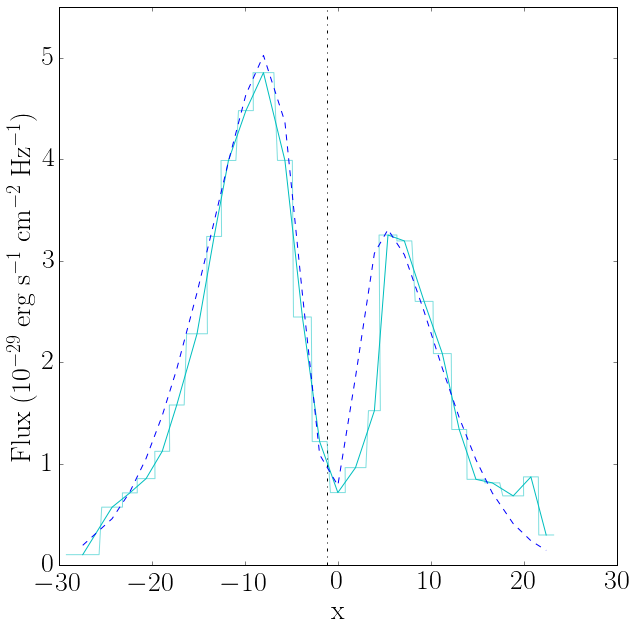

In [10]:
f = figure(figsize = (10,10))
plot(x_x, y_x, c='c', alpha=0.5)
plot(x_xp, y_xp, c='c')
plot(x_x_fit0, y_x_fit0, c='b', linestyle='--')
vlines(x_x[half],0,5.5,linestyle='-.')
xlabel('$\mathrm{x}$')
ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')
ylim(0,5.5)

In [11]:
#Empty arrays to save steps

amplitude_neg_walk = empty((0)) 
center_neg_walk = empty((0))
sigma_neg_walk = empty((0))
gamma_neg_walk = empty((0))
amplitude_pos_walk = empty((0)) 
center_pos_walk = empty((0))
sigma_pos_walk = empty((0))
gamma_pos_walk = empty((0))

l_walk = empty((0))

In [12]:
#Initial values

amplitude_neg_walk = append(amplitude_neg_walk, amplitude_neg0)
center_neg_walk = append(center_neg_walk, center_neg0)
sigma_neg_walk = append(sigma_neg_walk, sigma_neg0)
gamma_neg_walk = append(gamma_neg_walk, gamma_neg0)
amplitude_pos_walk = append(amplitude_pos_walk, amplitude_pos0)
center_pos_walk = append(center_pos_walk, center_pos0)
sigma_pos_walk = append(sigma_pos_walk, sigma_pos0)
gamma_pos_walk = append(gamma_pos_walk, gamma_pos0)

l_walk = append(l_walk, likelihood(y_xp, y_x_fit0))

In [ ]:
#MCMC Loop

n_steps = 50000

for i in range(n_steps):

    print i

    amplitude_neg_prime = random.normal(amplitude_neg_walk[i], 0.1) 
    center_neg_prime = random.normal(center_neg_walk[i], 0.1) 
    sigma_neg_prime = random.normal(sigma_neg_walk[i], 0.1) 
    gamma_neg_prime = random.normal(gamma_neg_walk[i], 0.1) 
    
    amplitude_pos_prime = random.normal(amplitude_pos_walk[i], 0.1) 
    center_pos_prime = random.normal(center_pos_walk[i], 0.1) 
    sigma_pos_prime = random.normal(sigma_pos_walk[i], 0.1) 
    gamma_pos_prime = random.normal(gamma_pos_walk[i], 0.1)
    
    y_previous = sum_2_skewed_gaussian(x_xp, amplitude_neg_walk[i], center_neg_walk[i], sigma_neg_walk[i], gamma_neg_walk[i], amplitude_pos_walk[i], center_pos_walk[i], sigma_pos_walk[i], gamma_pos_walk[i])
    y_prime = sum_2_skewed_gaussian(x_xp, amplitude_neg_prime, center_neg_prime, sigma_neg_prime, gamma_neg_prime, amplitude_pos_prime, center_pos_prime, sigma_pos_prime, gamma_pos_prime)
    
    l_previous = likelihood(y_xp, y_previous)
    l_prime = likelihood(y_xp, y_prime)

    a = l_prime / l_previous
    
    if(a <= 1.0):
        amplitude_neg_walk = append(amplitude_neg_walk, amplitude_neg_prime)
        center_neg_walk = append(center_neg_walk, center_neg_prime)
        sigma_neg_walk = append(sigma_neg_walk, sigma_neg_prime)
        gamma_neg_walk = append(gamma_neg_walk, gamma_neg_prime)
        amplitude_pos_walk = append(amplitude_pos_walk, amplitude_pos_prime)
        center_pos_walk = append(center_pos_walk, center_pos_prime)
        sigma_pos_walk = append(sigma_pos_walk, sigma_pos_prime)
        gamma_pos_walk = append(gamma_pos_walk, gamma_pos_prime)
        
        l_walk = append(l_walk, l_prime)

    else:
        
        b = random.random()
        
        if( log(b) <= -a):
            amplitude_neg_walk = append(amplitude_neg_walk, amplitude_neg_prime)
            center_neg_walk = append(center_neg_walk, center_neg_prime)
            sigma_neg_walk = append(sigma_neg_walk, sigma_neg_prime)
            gamma_neg_walk = append(gamma_neg_walk, gamma_neg_prime)
            amplitude_pos_walk = append(amplitude_pos_walk, amplitude_pos_prime)
            center_pos_walk = append(center_pos_walk, center_pos_prime)
            sigma_pos_walk = append(sigma_pos_walk, sigma_pos_prime)
            gamma_pos_walk = append(gamma_pos_walk, gamma_pos_prime)
            
            l_walk = append(l_walk, l_prime)
            
        else:
            amplitude_neg_walk = append(amplitude_neg_walk, amplitude_neg_walk[i])
            center_neg_walk = append(center_neg_walk, center_neg_walk[i])
            sigma_neg_walk = append(sigma_neg_walk, sigma_neg_walk[i])
            gamma_neg_walk = append(gamma_neg_walk, gamma_neg_walk[i])
            amplitude_pos_walk = append(amplitude_pos_walk, amplitude_pos_walk[i])
            center_pos_walk = append(center_pos_walk, center_pos_walk[i])
            sigma_pos_walk = append(sigma_pos_walk, sigma_pos_walk[i])
            gamma_pos_walk = append(gamma_pos_walk, gamma_pos_walk[i])
            
            l_walk = append(l_walk, l_previous)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
#Best values

amplitude_neg = amplitude_neg_walk[-1]
center_neg = center_neg_walk[-1]
sigma_neg = sigma_neg_walk[-1]
gamma_neg = gamma_neg_walk[-1]
amplitude_pos = amplitude_pos_walk[-1]
center_pos = center_pos_walk[-1]
sigma_pos = sigma_pos_walk[-1]
gamma_pos = gamma_pos_walk[-1]

print 'amplitude_neg = ', amplitude_neg
print 'center_neg = ', center_neg
print 'sigma_neg = ', sigma_neg
print 'gamma_neg = ', gamma_neg
print 'amplitude_pos = ', amplitude_pos
print 'center_pos = ', center_pos
print 'sigma_pos = ', sigma_pos
print 'gamma_pos = ', gamma_pos

amplitude_neg =  62.2503241026
center_neg =  -4.35495840591
sigma_neg =  9.04483265747
gamma_neg =  -2.9978642835
amplitude_pos =  36.309350827
center_pos =  3.35808522967
sigma_pos =  9.13879169678
gamma_pos =  4.25793702381


In [15]:
x_x_fit = x_xp
y_x_fit = sum_2_skewed_gaussian(x_x_fit, amplitude_neg, center_neg, sigma_neg, gamma_neg, amplitude_pos, center_pos, sigma_pos, gamma_pos)

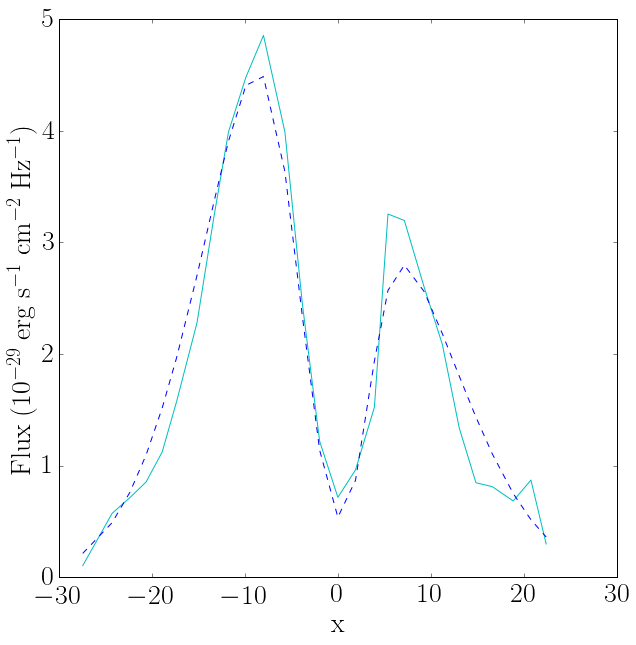

In [16]:
f = figure(figsize = (10,10))
plot(x_xp, y_xp, c='c')
plot(x_x_fit, y_x_fit, c='b', linestyle='--')
xlabel('$\mathrm{x}$')
ylabel('$\mathrm{Flux\;(10^{-29}\;erg\;s^{-1}\;cm^{-2}\;Hz^{-1})}$')
savefig('gaussian_fit_kulas.png')

In [17]:
gaussian_fit_file = open('gaussian_fit_kulas.dat','w')
gaussian_fit_file.write('amplitude_neg\tsigma_neg\tcenter_neg\tgamma_neg\tamplitude_pos\tsigma_pos\tcenter_pos\tgamma_pos\n')
gaussian_fit_file.write(str(amplitude_neg)+'\t'+str(sigma_neg)+'\t'+str(center_neg)+'\t'+str(gamma_neg)+'\t'+str(amplitude_pos)+'\t'+str(sigma_pos)+'\t'+str(center_pos)+'\t'+str(gamma_pos))
gaussian_fit_file.close()

In [18]:
print (1.0/2.0)*sum((y_xp-y_x_fit0)**2)
print (1.0/2.0)*sum((y_xp-y_x_fit)**2)

2.28820225924
1.25593912482
